# Non-Parametric Analysis

This notbook shows some of the uses of the non-parametric functions of the surpyval package.

In [1]:
import nonparametric as nonp
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

For these anlyses, we will go back to the beinging and use Weibull's original yield strength of bofors steel data. This is the yield strength, measured in (oddly) 1.275 kg/mm^2 and the number of observations.

In [3]:
x = np.array([32, 33, 34, 35, 36, 37, 38, 39, 40, 42])
n = np.array([10, 33, 81, 161, 224, 289, 336, 369, 383, 389])

# Mr Weibull's measurements are cumulative, so let's calculate the obervations at each point.
n = np.concatenate([[n[0]], np.diff(n)])

Using this data we can esimtate the reliability, that is, the probability that a sample of steel will survive up to a given applied stress. So what does that mean?

We can find when the steel will break. This is particularly useful when we know the application.

For this example, lets say that the maximum tensile stress our design will see during use is 33 units. Lets try and estimate the proportion that will fail during operation.

For this we can use the [Nelson-Aalen](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator) estimator of the hazard rate, then convert it to the reliability. This is all done with one easy call.

In [4]:
stress, r, d, R = nonp.nelson_aalen(x, n=n)

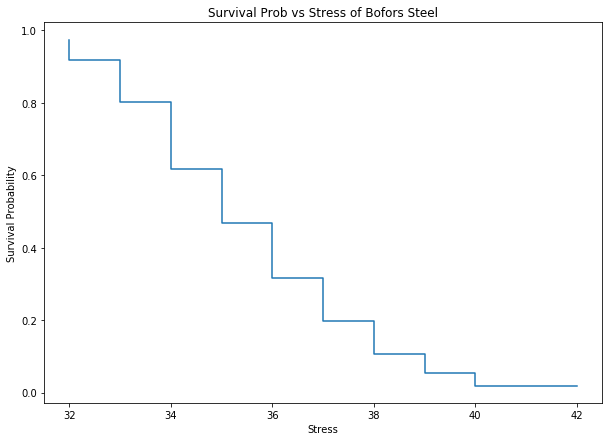

In [5]:
plt.figure(figsize=(10, 7));
plt.ylabel('Survival Probability')
plt.xlabel('Stress')
plt.step(stress, R)
plt.title('Survival Prob vs Stress of Bofors Steel');

So what purpose is this?

We can use these methods to estimate the reliability. Let's use the in built non-parametric model from surpyval. The default uses the Nelson-Aalen estimate.

In [6]:
bofors_steel = nonp.NonParametric.fit(x, n=n)

Now we have our non-parametric model of the Bofors steel. We can use this model to estimate the reliability in our application. Let's say that our application uses Bofors steel up to 34. What is our estimate of the number of failures?

In [7]:
bofors_steel.sf(34)

array([0.80153678])

The above shows that approximately 80% will survive up to 34. Therefore we will have an approximately 20% chance of our component failing under the stress in the design. It is up to the designer to determine whether this is acceptable.

What if we want to take into account our uncertainty about the reliability. The non-parametric class automatically computes the Greenwood variance and uses that to compute the upper and lower confidence intervals. Let's plot the intervals to see.

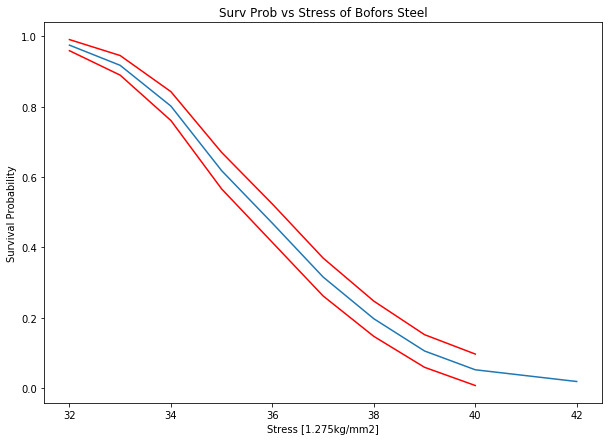

In [8]:
# Create the plot with confidence bound
plt.figure(figsize=(10, 7))
plt.plot(bofors_steel.x, bofors_steel.R)
plt.plot(bofors_steel.x, bofors_steel.cb_u, color='r')
plt.plot(bofors_steel.x, bofors_steel.cb_l, color='r')
plt.xlabel('Stress [1.275kg/mm2]')
plt.ylabel('Survival Probability')
plt.title('Surv Prob vs Stress of Bofors Steel');

We can use the in-built methods to estimate the confidence bounds. We will be concerned about underestimating the reliability. So let's calculate the lower confidence interval.

In [9]:
bofors_steel.R_cb(34, bound='lower', how='interp')

array([0.76054969])

Therefore we can be confident that the reliability at 34 is above 76%.

These methods work for three non-parametric methods that have been implemented. That is:
- Kaplan-Meier
- Nelson-Aalen
- Fleming-Harrington

For example, we can do the FH and KM estimates simply by:

In [10]:
bofors_steel_km = nonp.NonParametric.fit(x, n=n, how='Kaplan-Meier')
bofors_steel_fh = nonp.NonParametric.fit(x, n=n, how='Fleming-Harrington')

In [11]:
bofors_steel_km.R

array([0.97429306, 0.9151671 , 0.79177378, 0.58611825, 0.42416452,
       0.25706941, 0.13624679, 0.05141388, 0.01542416, 0.        ])

In [12]:
bofors_steel_fh.R

array([0.97432607, 0.91527604, 0.79204121, 0.58664986, 0.42490425,
       0.2580241 , 0.13735755, 0.05263678, 0.01670446, 0.00144149])

In [13]:
bofors_steel.R

array([0.97462067, 0.91723373, 0.80153678, 0.61818675, 0.46893999,
       0.31625075, 0.19765744, 0.10604822, 0.05266199, 0.01937326])

We can see that the estimates for each of the three methods are roughly the same. Interestingly, the Kaplan-Meier estimate reaches 0.